In [83]:
#!/usr/bin/python3
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp

# Constants in model
g = 9.792

# Constants
m = 0.733 # max (starting) mass
mass_min = 0.200

# Mass function
def m(t):
    if mass_min + (0.532 * (1.5 - t)) / 1.5 < mass_min:
        return mass_min
    return mass_min + (0.532 * (1.5 - t)) / 1.5

# Thrust function
def T(x,max_thrust):
    scaling = np.sqrt(max_thrust)/0.75
    parabolic_bracket = (x*scaling - np.sqrt(max_thrust))
    return max(-(parabolic_bracket*parabolic_bracket) + max_thrust,0)

rho = 1.22264 # air density (kg/m^3) 
CD = 0.697 # coefficient of drag 
A = 0.00456 # cross-sectional area (m^2) 

In [84]:
# Function that evaluates the RHS of the ODE. It has two components
# v = [x': velocity, v': acceleration]
def f(t, v):
    # if v[1] < -np.sqrt((2 * m(t) * g) / (CD * A * rho)):
    # if v[0] < 0:
    #     return([0, 0])
    D = -(1/2) * rho * CD * A * v[1] * v[1] # Drag force
    # D = 0
    if v[1] < 0:
        D = -1 * D

    if v[1] < -g:
        return([v[1], 0])
        # return np.array([v[1],\
        #              (1/m) * (T(t) - m * g - (1/2) * rho * CD * A * v[1] * v[1])])
    return np.array([v[1],\
                    (1/m(t)) * (T(t, 250) - m(t) * g + D)])

Max height: 449.2776204033932
Max velocity: 288.7746352985154
-31.748088892596847


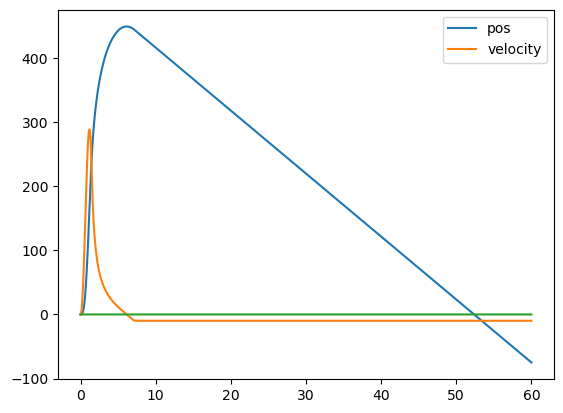

In [85]:
# Initial conditions, set to the initial populations
yinit=np.array([0,0])
t_max = 60
t = np.linspace(0, t_max, t_max * 100)

# Solve ODE using the "odeint" library in SciPy
y=solve_ivp(f, [0, t_max], yinit, t_eval=t, method='RK45')
print('Max height:', max(y.y[0]))
print('Max velocity:', max(y.y[1]))
print(-np.sqrt((2 * mass_min * g) / (CD * A * rho)))
# Plot the solutions
plt.figure()
plt.plot(t, y.y[0], label='pos')
plt.plot(t, y.y[1], label='velocity')
plt.plot(t, np.zeros(len(t)))
plt.legend()
plt.show()

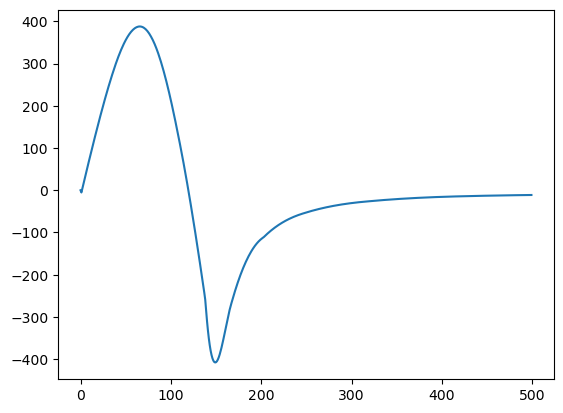

In [86]:
last = 0
a = []
for v in y.y[1]:
    a.append((v - last)*100)
    last = v 
a
# print(a.index(max(a[:500])))
plt.plot(a[:500], label='acceleration')

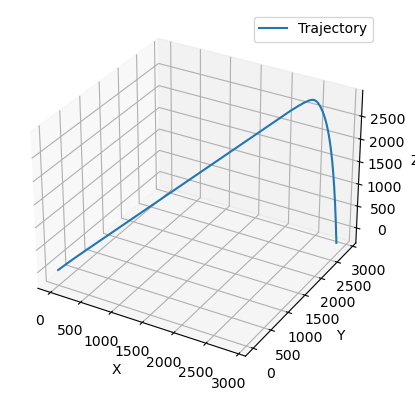

In [87]:
#!/usr/bin/python3
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
import os
from PIL import Image


# Constants in model
g = 9.792

# Constants
m = 0.733 # max (starting) mass
mass_min = 0.200

# Mass function
def m(t):
    if mass_min + (0.532 * (1.5 - t)) / 1.5 < mass_min:
        return mass_min
    return mass_min + (0.532 * (1.5 - t)) / 1.5

# Thrust function
def thrust(t, t_ignition, t_cutoff, max_thrust):
    if t < t_ignition:
        return max_thrust * (t / t_ignition)
    elif t_ignition <= t <= t_cutoff:
        return max_thrust
    elif t > t_cutoff:
        return 0

# Constants for thrust function
t_ignition = 0.5
t_cutoff = 10
max_thrust = 250


rho = 1.22264 # air density (kg/m^3) 
CD = 0.697 # coefficient of drag 
A = 0.00456 # cross-sectional area (m^2) 

# Launch angles
theta = np.radians(45) # angle between thrust and the vertical axis in the x-z plane
phi = np.radians(45) # angle between thrust and the vertical axis in the x-y plane

# Constants
CD_x = 0.697  # coefficient of drag in the x-direction
A_x = 0.00456 # cross-sectional area in the x-direction (m^2)

CD_y = 0.697  # coefficient of drag in the y-direction
A_y = 0.00456 # cross-sectional area in the y-direction (m^2)

CD_z = 0.697  # coefficient of drag in the z-direction
A_z = 0.00456 # cross-sectional area in the z-direction (m^2)

tx_ls = []
# ODE function
def f(t, v):
    D_x = -(1/2) * rho * CD_x * A_x * v[3] * v[3]
    D_y = -(1/2) * rho * CD_y * A_y * v[4] * v[4]
    D_z = -(1/2) * rho * CD_z * A_z * v[5] * v[5]

    if v[3] < 0:
        D_x = -1 * D_x
    if v[4] < 0:
        D_y = -1 * D_y
    if v[5] < 0:
        D_z = -1 * D_z
        
    T_x = thrust(t, t_ignition, t_cutoff, max_thrust) * np.cos(theta) * np.cos(phi)
    T_y = thrust(t, t_ignition, t_cutoff, max_thrust) * np.cos(theta) * np.sin(phi)
    T_z = thrust(t, t_ignition, t_cutoff, max_thrust) * np.sin(theta)
    

    
    tx_ls.append(D_z)
    return np.array([v[3],\
                     v[4],\
                     v[5],\
                     (1/m(t)) * (T_x + D_x),\
                     (1/m(t)) * (T_y + D_y),\
                     (1/m(t)) * (T_z - m(t) * g + D_z)])


# Initial conditions
yinit = np.array([0, 0, 0, 0, 0, 0])

t_max = 120
t = np.linspace(0, t_max, t_max * 100)

# Solve ODE
y = solve_ivp(f, [0, t_max], yinit, t_eval=t, method='RK45')

# Plot the solutions in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(y.y[0], y.y[1], y.y[2], label='Trajectory')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()


In [88]:
len(t)

12000

In [89]:
len(y.y[0])

12000

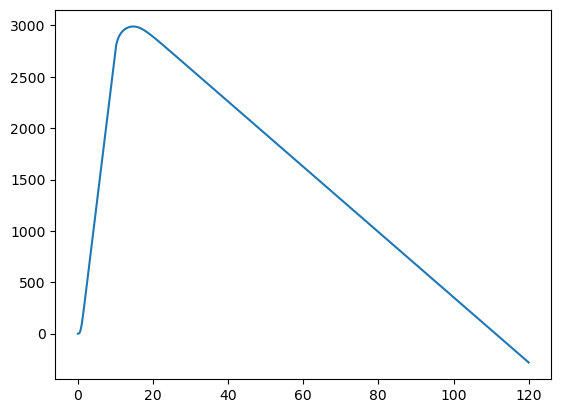

In [90]:
plt.plot(t, y.y[2])